# **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.cluster import KMeans
import import_ipynb
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist

import Utility
from Utility import *

importing Jupyter notebook from Utility.ipynb


 ## Read Music Data

In [2]:
tracks = pd.read_csv(r"datasets/data.csv")

## Content-based Filtering Song Recommendation


Content-based filtering uses similarities in products, services, or content features, as well as information accumulated about the user to make recommendations. In our case we have created a recommendation system which recommends songs based on similar songs.
Music Recommender based on different KMeans and PCA algorithm

1. **PCA_algorithm**: to reduce the dimensionality (in our case number of components is 2) within a dataset while still retaining as much information as possible.

2. **KMeans_with_PCA_algorithm**: algorithm that tries to partition the dataset into Kpre-defined distinct non-overlapping clusters. 
    Based on the values of the Within Cluster Sum of Squares (WCSS) and an approach known as the Elbow method, we made a decision about how many clusters we’d like to keep.In our case, we have kept number of cluster as 3.

3. we have then created a new data frame df_segm_pca_kmeans. It allows us to add in the values of the separate components to our segmentation data set. The components’ scores are stored in the ‘scores P C A’ variable. Let’s label them com1 and com2.

4. **filter_based_on_segment**: filters songs that belong to particulat cluster segment.

5. **filter_based_on_cluster_centroid**: filters songs based on closet distance of song and centroid


In [3]:
def recommend_songs(song_id, n_songs=10):
  
    """
    Recommends songs based on a list of previous songs that a user has listened to.
    """
    song_embedding = PCA_algorithm(tracks)
    
    kmeans_pca , centroids = KMeans_with_PCA_algorithm(song_embedding,3)

    #get Segment K-means PCA from song_id argument
    df_segm_pca_kmeans = pd.concat([tracks.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
    df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
    df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

    #get segment value of song_id
    segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['id'] == song_id]['Segment K-means PCA'].values[0]
    
    filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val,'id', 'name')   

    rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks)

    #recommend top n songs
    return rec_songs.head(n_songs)['name'].tolist()

In [4]:
song_embedding = PCA_algorithm(tracks)
    
kmeans_pca , centroids = KMeans_with_PCA_algorithm(song_embedding,3)

#get Segment K-means PCA from song_id argument
df_segm_pca_kmeans = pd.concat([tracks.reset_index(drop=True), pd.DataFrame(song_embedding)],axis=1)
df_segm_pca_kmeans.columns.values[-2:] = ['com1','com2']
df_segm_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

#get segment value of song_id
segment_val = df_segm_pca_kmeans[df_segm_pca_kmeans['id'] == '3w3cxwYuR7ThpE8KVSys5x']['Segment K-means PCA'].values[0]

filtered_data_per_segment = filter_based_on_segment(df_segm_pca_kmeans,segment_val,'id', 'name')   

rec_songs = filter_based_on_cluster_centroid(kmeans_pca,filtered_data_per_segment,segment_val,tracks)

print(rec_songs.head(10))

                            id                                   name  \
158230  1fhZVXKWlS3yRTcPz3zDtA                  The Sentimental Touch   
125026  5CeSVTo0lIY8juoR2GRxGp                        Beulah's Boogie   
42684   1VasxEH5DA1K3fpyXRibyy                              Stew Ball   
25334   73TLwAzi8m24i62ZEwws5h                           Was I Wazir?   
78555   0ZgVX9FryofZNrD20M8JQd                         Sonora Querida   
57745   3xHpx7oDetu7uempkFKR3W  Opening Act II: Sports of Gay Chicago   
41136   2rjjJ730fXFnSX2TKWNwaB        Hava Nagila (Sung in Hungarian)   
61792   04gZ18dV6O3Vs2gZa3G2Hv                  My Little Her and Him   
157643  61XjA7DOi3BZjYqW86NLYK                  Pravazhanye (Parting)   
77249   4L2w6eS4o5PDJ5fwbuphxA                        Nanu Paalimpaga   

            com1      com2  Segment K-means PCA  
158230  1.202301 -1.539281                    1  
125026  1.197977 -1.549301                    1  
42684   1.207751 -1.521130                    

C:\Users\shris\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


Finds similar songs based on the selected song using its song_id 
Recommends Top N song(s). In  our case, we have recommended top 10 songs

In [5]:
recommend_songs_list = recommend_songs("3w3cxwYuR7ThpE8KVSys5x")
recommend_songs_list

C:\Users\shris\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


['Θειακό συρτό Γιαννιώτικο',
 'Reliquias Porteñas - Instrumental (Remasterizado)',
 'Jeevahimsa Maanandi',
 'My Little Her and Him',
 "Kringle's Jingle",
 'Opening Act II: Sports of Gay Chicago',
 'Tacos, Enchiladas And Beans',
 'The Sentimental Touch',
 'Aai Baharen Leke Raaten Pyar Ki',
 'Stew Ball']

In [6]:
#!pip install circlify

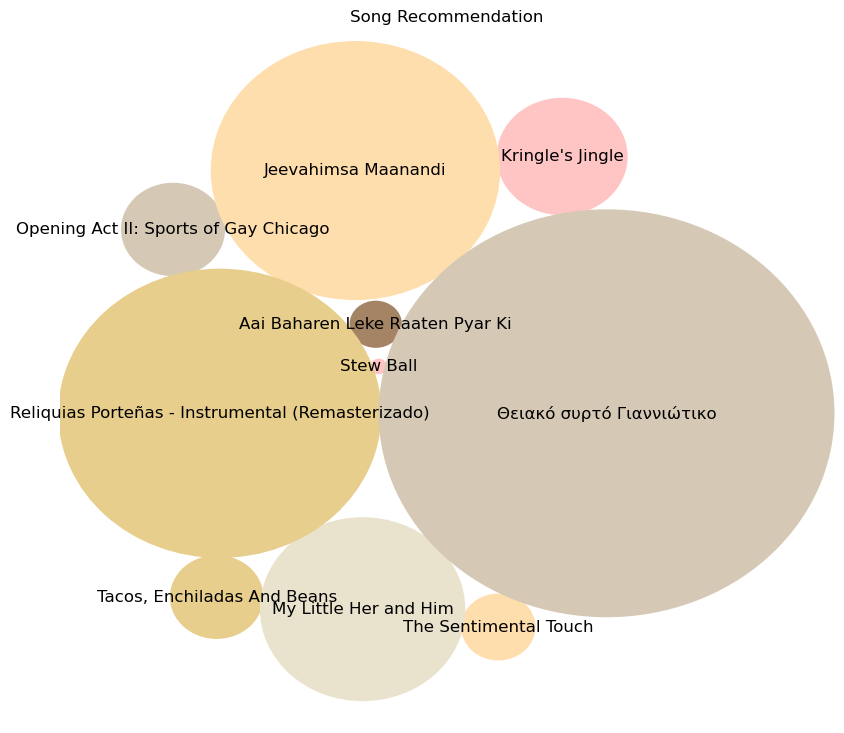

In [7]:
import matplotlib.pyplot as plt
import pandas as pd
import circlify
from matplotlib.offsetbox import AnnotationBbox

df = pd.DataFrame({'Name': recommend_songs_list,
                   'Value': [1000, 500, 400, 200, 80, 50, 40, 25, 12, 1]})
df = df.sort_values('Value') 
circles = circlify.circlify(df['Value'].tolist(),
                            target_enclosure=circlify.Circle(x=0, y=0, r=1))

fig, ax = plt.subplots(figsize=(10, 9))

ax.set_title('Song Recommendation')
ax.axis('off')  

lim = max(max(abs(circle.x) + circle.r, abs(circle.y) + circle.r, )
          for circle in circles)
ax.set_xlim(-lim, lim)
ax.set_ylim(-lim, lim)

labels = df['Name']  
colors = ['#ffc4c4','#a48465','#ffdead','#e7ce8c','#d5c9b6','#ffc4c4','#e9e3ce','#ffdead','#e7ce8c','#d5c9b6']
for circle, label, color in zip(circles, labels, colors):
    x, y, r = circle
    ax.add_patch(plt.Circle((x, y), r, linewidth=2, color=color))
    ax.annotate(label, (x, y), va='center', ha='center', size=12)
plt.show()

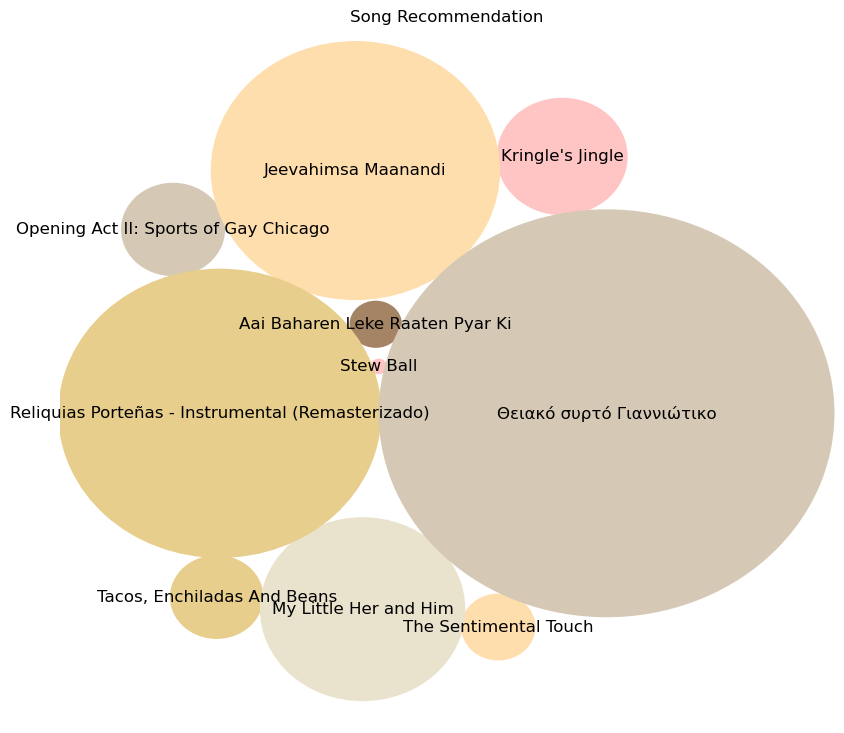

<module 'matplotlib.pyplot' from 'C:\\Users\\shris\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [8]:
circlify_vizualization(recommend_songs_list)